In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
# Cross Validating
from sklearn.model_selection import train_test_split, cross_val_score

# For RF Evaluation and Permutation Importance

from rfpimp import importances, plot_importances
from rfpimp import plot_corr_heatmap

## Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

#

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score


Welcome to the TaskRabbit data science exercise.  We appreciate your
time and effort in completing this exercise.  It helps TaskRabbit
focus on candidates who are the best fit for the Data Scientist role,
and also helps the candidate get an idea of the type of data we work
with and the technical skills required to be successful in the role.

For this exercise, a sample data file is provided which contains
information about "recommendations".  A "recommendation" is the group
of Taskers from which the Client can choose one to book. In this
sample data, each recommendation can have up to 15 Taskers shown.

With this exercise, we want to understand what makes a Client choose a
Tasker. In particular, we want to use market data to build a model
that suggests hourly rates to Taskers that would maximize their
opportunity to be hired.


* **recommendation_id**
unique identifier for this recommendation, or set of taskers shown
* **timestamp**
when this recommendation was shown to the client
* **tasker_id**
unique identifier for the Tasker
* **position**
the position of the Tasker in the recommendation set, 1 - first, 2 - second, etc.
* **hourly_rate**
the hourly rate for the Tasker when they were shown
* **num_completed_tasks**
the number of Tasks the Tasker had completed in that category, when they were shown
* **hired**
was the Tasker hired or not?  Only 1 tasker out of a set of recommendations can be hired
* **category**
the category of work the Client needs help with

* Please describe in detail your approach, with code and visualization
that support your model. What are your dependent and independent
variables? Note that the ranking position is out of the Tasker’s
control, and so also make an argument as to whether you decided to use
this information in your model.


In [190]:
data = pd.read_csv('data/taskrabbitdata.csv')

In [191]:
data.head()

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1006892359,2,40,193,0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1012023956,3,28,0,0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009733517,4,43,303,0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1013579273,5,29,39,0,Furniture Assembly


In [192]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
recommendation_id      30000 non-null object
created_at             30000 non-null object
tasker_id              30000 non-null int64
position               30000 non-null int64
hourly_rate            30000 non-null int64
num_completed_tasks    30000 non-null int64
hired                  30000 non-null int64
category               30000 non-null object
dtypes: int64(5), object(3)
memory usage: 1.8+ MB


In [193]:
data.describe()

,tasker_id,position,hourly_rate,num_completed_tasks,hired
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.011072e+09,7.873600,57.482533,221.235700,0.056833
std,2.501822e+06,4.319442,36.222860,279.801812,0.231528
min,1.006647e+09,1.000000,18.000000,0.000000,0.000000
25%,1.008955e+09,4.000000,38.000000,23.000000,0.000000
50%,1.010579e+09,8.000000,45.000000,114.000000,0.000000
75%,1.013444e+09,12.000000,60.000000,300.250000,0.000000
max,1.015020e+09,15.000000,290.000000,1406.000000,1.000000


looking into feature correlations. not seeing super strong correlations, 0.29 with hourly rate is the largest one



Text(0.5, 1.0, 'Feature Correlations \n All Counties')

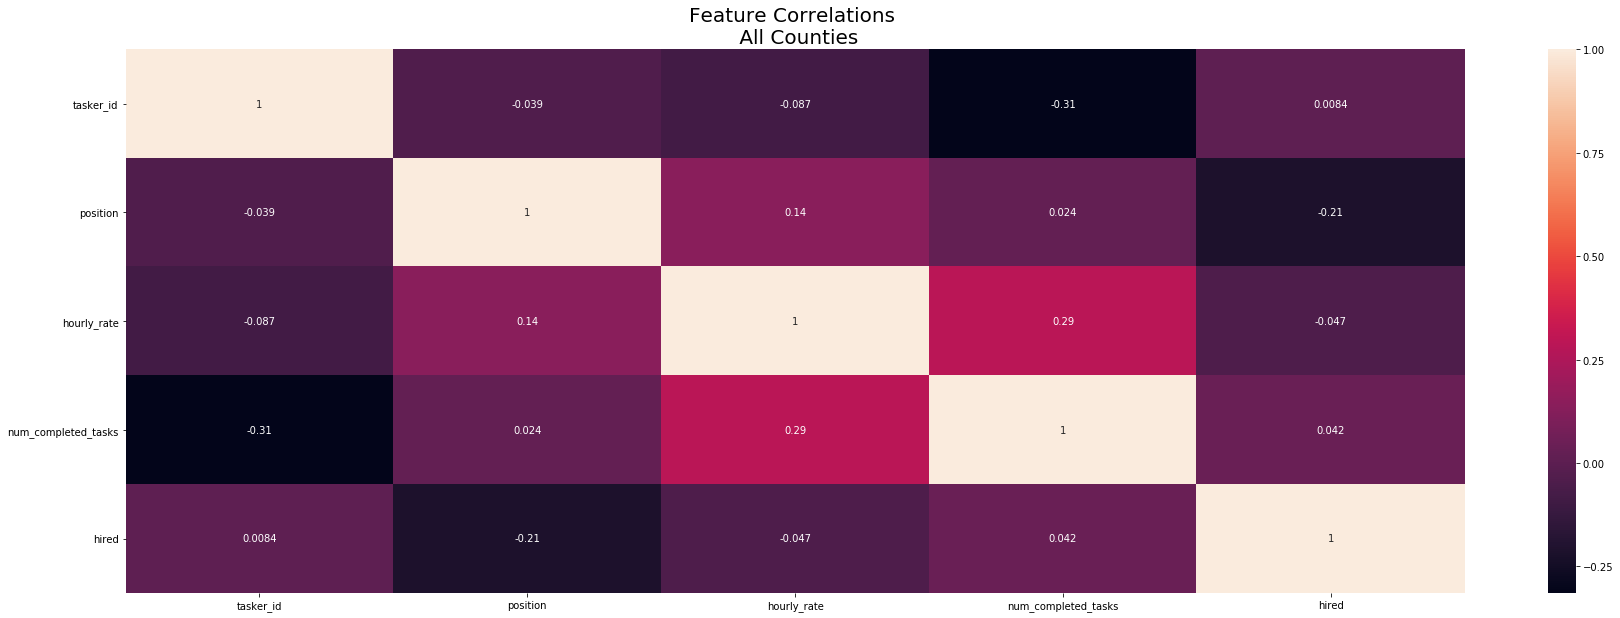

In [194]:
# feature correlation matrix
plt.figure(figsize = (30, 10))
sns.heatmap(data.corr(), annot = True)
plt.title('Feature Correlations \n All Counties', fontsize = 20)

Starting EDA for each feature

In [195]:
data.hired.value_counts()
print('% of hired Taskers in the dataset',data.hired.value_counts().values[1]/data.hired.value_counts().values[:].sum()*100)


% of hired Taskers in the dataset 5.683333333333334


Text(0, 0.5, 'hourly_rate')

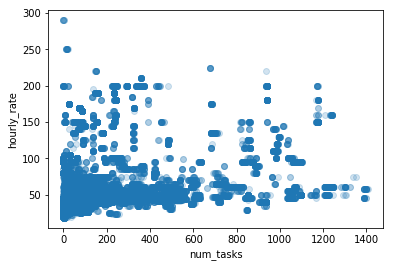

In [230]:
# scatter plots to see relationship between hourly rate and number of completed tasks
x = data.num_completed_tasks
y = data.hourly_rate
plt.scatter(x, y, alpha=0.2)
plt.xlabel('num_tasks')
plt.ylabel('hourly_rate')

Text(0, 0.5, 'recommendation position')

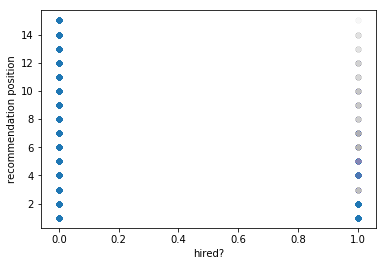

In [245]:
x = data.hired
y = data.position
plt.scatter(x, y, alpha = 0.005)
plt.xlabel('hired?')
plt.ylabel('recommendation position')
# we can't concude fromt his plot that hiring outcome is cause by recommendation position

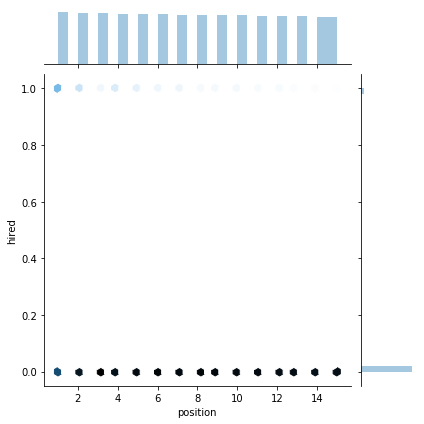

In [239]:
sns.axes_style('white')
sns.jointplot( y,x,  kind='hex')

(0, 250)

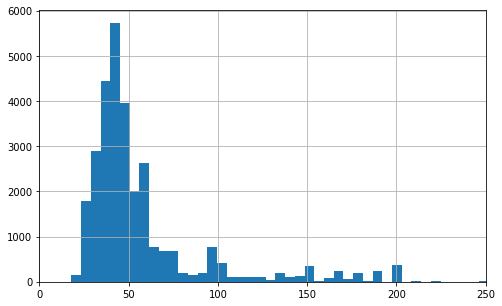

In [198]:
data.hourly_rate.hist(bins = 50, figsize = (8, 5))
plt.xlim(0,250)

In [199]:
# 2100 unique recommendations id
len(data.recommendation_id.value_counts())

2100

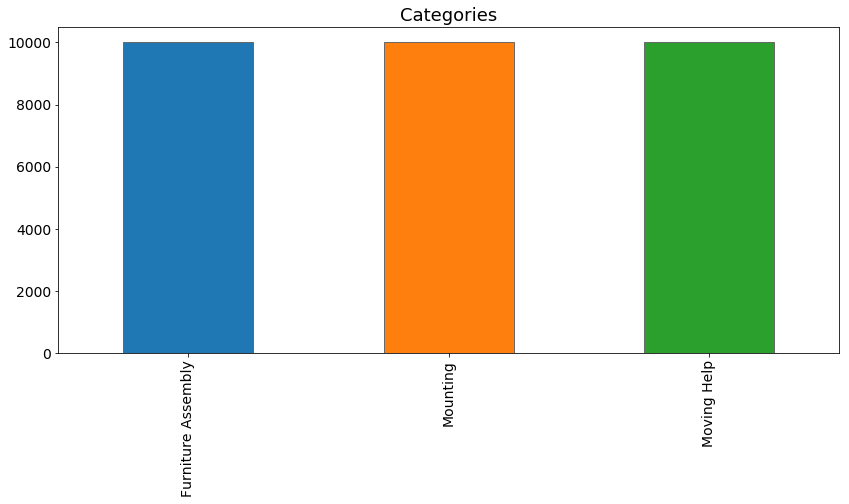

In [200]:
# looking at the distributions of categories - # we have 3 categories with even 10000 numbers of records
plt.title('Categories', fontsize = 18)

plt.grid(c = 'lemonchiffon', linestyle = '--')
ax = data.category.value_counts().sort_index().plot.bar(
    figsize = (14,6),
    fontsize = 14, edgecolor='dimgrey')

Text(0.5, 0, 'Hourly Rate')

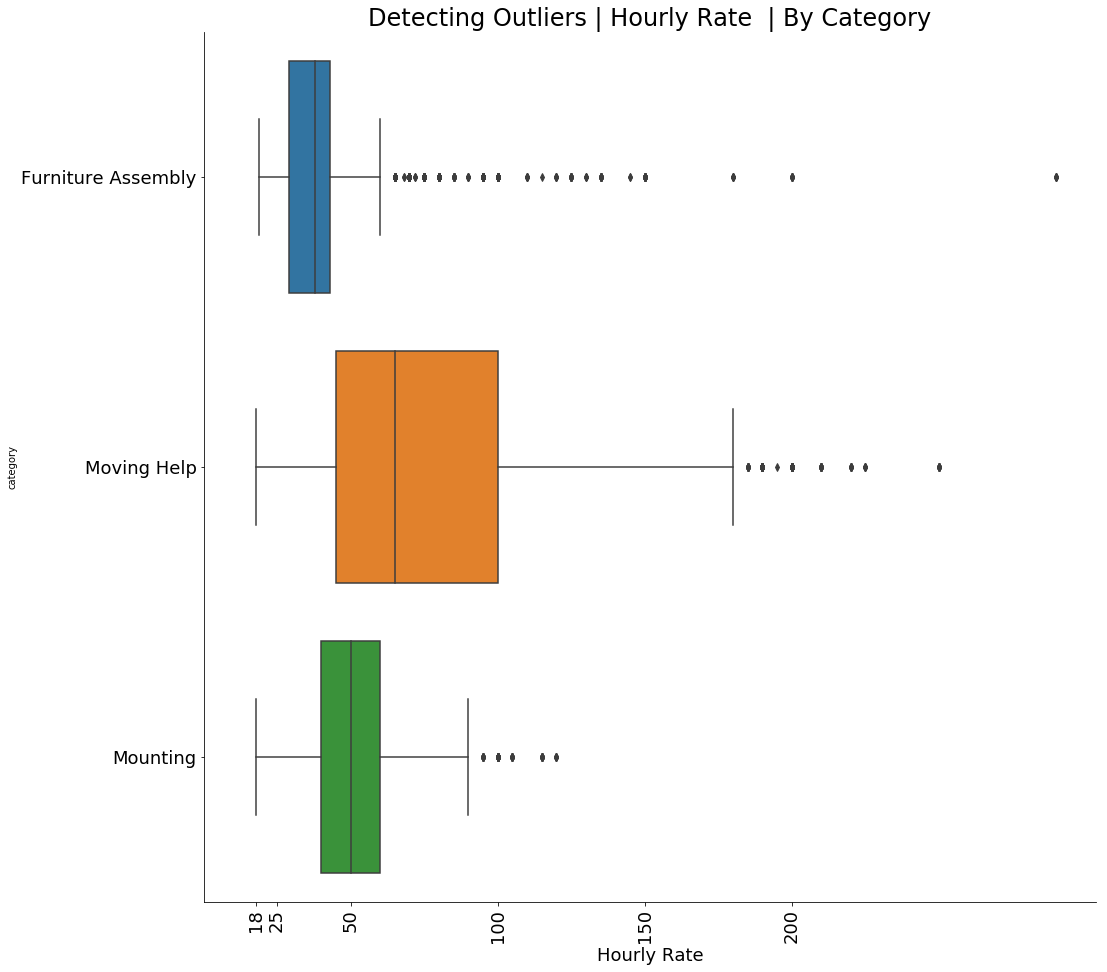

In [201]:
## lets look at the outliers 
fig, ax = plt.subplots(figsize=[16, 16])
sns.boxplot(
    data=data,
    y=data.category,
    x=data.hourly_rate
)
ax.set_title('Detecting Outliers | Hourly Rate  | By Category', fontsize = 24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(0,)
plt.xticks(( 18, 25, 50, 100,  150, 200), fontsize = 18, rotation = 90)
plt.yticks(fontsize = 18)
plt.xlabel('Hourly Rate', fontsize = 18)

### Lets look separately at hte category "furniture assembly to see what we can find"

In [202]:
fa_mask = data.category == 'Furniture Assembly'

In [203]:
fa = data[fa_mask]

In [204]:
len(fa)

10000

In [205]:
fa.describe() # from num of completed tasks we can see that there are some outliers there

,tasker_id,position,hourly_rate,num_completed_tasks,hired
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.010953e+09,7.880100,39.419700,185.833800,0.057200
std,2.359695e+06,4.324534,16.866126,247.091499,0.232236
min,1.006702e+09,1.000000,19.000000,0.000000,0.000000
25%,1.009069e+09,4.000000,29.000000,15.000000,0.000000
50%,1.010258e+09,8.000000,38.000000,75.000000,0.000000
75%,1.013407e+09,12.000000,43.000000,259.000000,0.000000
max,1.015018e+09,15.000000,290.000000,1396.000000,1.000000


#### Grouping by tasker



In [206]:
# for furniture assembly we have 514 unique taskers
len(fa.tasker_id.value_counts())

514

In [234]:
fa.groupby('tasker_id')[['position', 'hourly_rate', 'hired']]

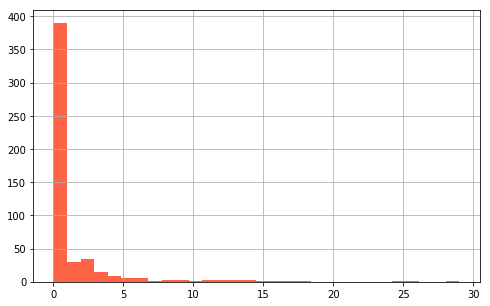

In [207]:
fa.groupby('tasker_id')['hired'].sum().hist(bins = 30, figsize = (8,5), color = 'Tomato')

In [208]:
fa.groupby('tasker_id')['hired'].sum()

tasker_id
1006702141    0
1006712342    0
1006720321    1
1006720473    0
1006751673    0
1006853970    0
1006892359    6
1006912729    0
1006958026    0
1006997279    0
1007007551    0
1007030973    0
1007062502    0
1007064489    0
1007081910    9
1007084219    0
1007146669    0
1007164698    1
1007184581    0
1007227664    0
1007281889    0
1007283421    0
1007306634    0
1007338344    2
1007341779    0
1007383273    0
1007387389    0
1007434113    0
1007472401    0
1007477780    0
             ..
1014501186    0
1014503419    0
1014508755    0
1014532398    0
1014539109    0
1014551627    0
1014578899    0
1014586046    0
1014632169    0
1014640927    0
1014657461    0
1014659781    0
1014675294    2
1014697426    0
1014702607    6
1014710322    0
1014758340    4
1014790265    0
1014832736    0
1014860648    0
1014881086    0
1014901856    0
1014928212    0
1014960300    6
1014979388    2
1014983247    0
1015000442    0
1015009096    0
1015015238    2
1015018182    0
Name: hired, L

In [209]:
fa.groupby('tasker_id')['hourly_rate'].min().head(5)

tasker_id
1006702141    27
1006712342    25
1006720321    27
1006720473    29
1006751673    30
Name: hourly_rate, dtype: int64

### Now I want to attempt to build a random forrest model

In [210]:
# preparing data
# Data prep
fa = fa.copy()
fa = fa._get_numeric_data()


fa_rf = fa[['position', 'hourly_rate', 'num_completed_tasks', 'hired']].dropna()

features = fa_rf.drop(['hired'], 1)

In [211]:
X = fa_rf.drop(['hired'], 1).values

y = fa_rf['hired']
X.shape, y.shape

((10000, 3), (10000,))

In [228]:
# splitting the training set for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [212]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0.]
Test score:  0.9445


As the Dummy Classifier predicts only Class 0, it is clearly not a good option for our objective of correctly classifying if the tasker will be hired.

Let's see how logistic regression performs on this dataset.

In [213]:
# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)
# Checking accuracy
accuracy_score(y_test, lr_pred)

0.693

In [214]:
# Checking unique values
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0.0    1317
1.0     683
Name: 0, dtype: int64

In [215]:
fa.hired.value_counts()
print('% of hired Taskers for Furniture Assembly in the dataset',fa.hired.value_counts().values[1]/fa.hired.value_counts().values[:].sum()*100)


% of hired Taskers for Furniture Assembly in the dataset 5.72


In [221]:
from sklearn.utils import resample
# concatenate our training data back together
X = pd.concat([features, y_train], axis=1)
X.head()

,position,hourly_rate,num_completed_tasks,hired
0,1,38,151,0.0
1,2,40,193,0.0
2,3,28,0,0.0
3,4,43,303,0.0
4,5,29,39,0.0


In [222]:
# separate minority and majority classes
not_hired = X[X.hired==0]
hired = X[X.hired==1]

# upsample minority
hired_upsampled = resample(hired,
                          replace=True, # sample with replacement
                          n_samples=len(not_hired), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_hired, hired_upsampled])

# check new class counts
upsampled.hired.value_counts()

1.0    7539
0.0    7539
Name: hired, dtype: int64

In [223]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.hired
X_train = upsampled.drop('hired', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)
# Checking accuracy
accuracy_score(y_test, upsampled_pred)

0.693

In [224]:
# f1 score
f1_score(y_test, upsampled_pred)

0.22670025188916879

In [225]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, upsampled_pred))

,0,1
0,1296,593
1,21,90


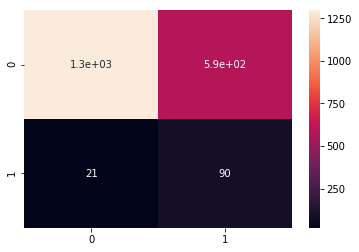

In [226]:
# Evaluating on Training Test
cm = confusion_matrix(y_test, upsampled_pred)
sns.heatmap(cm, annot= True)

In [227]:
recall_score(y_test, upsampled_pred)

0.8108108108108109

# trying to use SMOTE

In [61]:
rf = RandomForestClassifier(max_depth=2, random_state=0,
                             n_estimators=1000)
rf.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [62]:
y_predict_train = rf.predict(X_train)

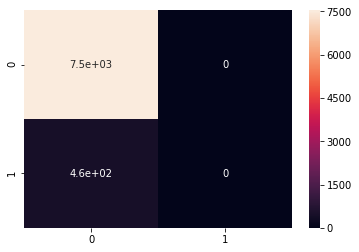

In [65]:
# Evaluating on Training Test
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot= True)

In [66]:
# Training Results
print(classification_report(y_train, y_predict_train))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7539
           1       0.00      0.00      0.00       461

   micro avg       0.94      0.94      0.94      8000
   macro avg       0.47      0.50      0.49      8000
weighted avg       0.89      0.94      0.91      8000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


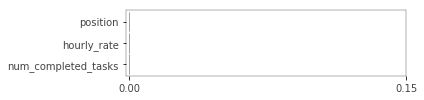

                     Importance
Feature                        
position                    0.0
hourly_rate                 0.0
num_completed_tasks         0.0


In [60]:
imp =importances(rfr, fa_rf.drop(['hired'], 1), fa_rf['hired'])
viz = plot_importances(imp,width=6, vscale=2)
viz.view()
print(imp)


In [111]:
# ok I'll try to use SMOTE, then run RF model )or other model, and then partial dependence plots

from collections import Counter
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X, y)